In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gamma
from scipy.special import erf
from scipy.signal import welch
import warnings
warnings.filterwarnings(action='ignore');
import rainflow
from scipy.signal import lfilter

In [2]:
def fileO(x,y,filename):
    f = open(filename,'w');
    #f = open(filename,'a'); # overwrite
    for i in range(len(y)):
        f.write('%.4e\t%.4e\n'%(x[i],y[i]));
    f.close();

In [3]:
def bs_overlap(dfi,dpi,p): # 각 band의 데이터 수 x p(%) 만큼 overlap
    nb = len(dpi);
    ndata, pndata = np.zeros(nb,int),np.zeros(nb,int);
    dfi1 = np.copy(dfi); dpi1 = np.copy(dpi);
    for i in range(nb):
        ndata[i] = len(dpi[i]);
        pndata[i] = int(ndata[i]*p);
    for i in range(nb-1):
        dfi1[i] = np.concatenate([dfi[i],dfi[i+1][1:pndata[i+1]+1]]);
        dpi1[i] = np.concatenate([dpi[i],dpi[i+1][1:pndata[i+1]+1]]);
    for i in range(1,nb):        
        dfi1[i] = np.concatenate([dfi[i-1][-pndata[i]:1],dfi1[i]]);
        dpi1[i] = np.concatenate([dpi[i-1][-pndata[i]:1],dpi1[i]]);     
    return dfi1,dpi1

In [4]:
def psdinteg(freq,psd):
    f = freq; y = psd;
    ndata = len(y);
    a = np.zeros(ndata-1);
    for i in range(ndata-1):
        if y[i] != 0 and y[i+1] != 0:
            n = np.log10(y[i+1]/y[i])/np.log10(f[i+1]/f[i]);
            if n == -1:
                a[i] = y[i]*f[i]*np.log(f[i+1]/f[i]);
            else:
                a[i] = (y[i]/(f[i]**n))*(1/(n+1))*(f[i+1]**(n+1)-f[i]**(n+1));
    return np.sqrt(sum(a))

In [5]:
def psd2th_wn(freq,psd,dur):
    def psdinteg(freq,psd):
        f = freq; y = psd;
        ndata = len(y);
        a = np.zeros(ndata-1);
        for i in range(ndata-1):
            if y[i] != 0 and y[i+1] != 0:
                n = np.log10(y[i+1]/y[i])/np.log10(f[i+1]/f[i]);
                if n == -1:
                    a[i] = y[i]*f[i]*np.log(f[i+1]/f[i]);
                else:
                    a[i] = (y[i]/(f[i]**n))*(1/(n+1))*(f[i+1]**(n+1)-f[i]**(n+1));
        return np.sqrt(sum(a))
    def log_interp(x,x_spec,y_spec):
        return 10**np.interp(np.log10(x),np.log10(x_spec),np.log10(y_spec), left=-10, right=-10);
    
    fmax = max(freq);
    tmax = dur;
    fs = fmax * 20.
    dt = 1 / fs

    spec_grms = psdinteg(freq,psd);

    Nt = int(np.ceil(tmax / dt))
    Nt3 = 3 * Nt
    
    # num_fft = 2의 n승
    Nt=2**int(np.ceil(np.log(Nt)/np.log(2)));  
    df = 1. / (Nt * dt);
    
    # White Noise
    wn = np.random.normal(0,1,Nt);
    
    Nf = int(Nt / 2)

    fft_freq = np.linspace(0, (Nf - 1) * df, Nf)
    fft_freq2 = np.linspace(0, (Nt - 1) * df, Nt)
    
    spec = np.zeros(Nf, float)
    sq_spec = np.zeros(Nf, float)
    
    js = 0
    
    if(fft_freq[0]<=0):
        fft_freq[0]=0.5*fft_freq[1];        
    
    sq_spec = np.sqrt(log_interp(fft_freq,freq,psd));
    
    Y = np.zeros(Nt, complex)

    YF = np.fft.fft(wn)
    
    YFn=YF[0:Nf]

    Y[0:Nf]=sq_spec*YFn

    Y[0]=0.
    
    for j in range(1, Nf):
        Y[Nt - j] = complex(Y[j].real, -Y[j].imag)
    
    YI = np.fft.ifft(Y)  
    
    psd_th = YI.real
    
    Nt = len(psd_th)
    
    time = np.linspace(0, (Nt - 1) * dt, Nt)
    
    syn_grms = np.std(psd_th)
    
    psd_th *= (spec_grms / syn_grms)
    
    return time,psd_th;

In [6]:
def band_split(fi,pi,nb): # fi : interpolated freq, ai : interpolated psd, nb : # of bands
    ni = len(fi);
    grms = np.sqrt(np.trapz(pi,fi))
    goal = grms/np.sqrt(nb);  # target grms
    idx = np.zeros(nb+1,'int');
    grms_tmp = 0;
    for i in range(1,nb):
        while(grms_tmp < goal):
            idx[i] += 1;
            grms_tmp = np.sqrt(np.trapz(pi[idx[i-1]:idx[i]],fi[idx[i-1]:idx[i]]));
        grms_tmp1 = np.sqrt(np.trapz(pi[idx[i-1]:idx[i]-1],fi[idx[i-1]:idx[i]-1]));
        if np.abs(grms_tmp1 - goal) < np.abs(grms_tmp - goal):
            idx[i] += 1;
        grms_tmp = 0; grms_tmp1 = 0;
    idx[0] = 0; idx[nb] = len(pi);
    dfi = []; dpi = [];
    for i in range(nb):
        dfi.append(fi[idx[i]:idx[i+1]+1]); dpi.append(pi[idx[i]:idx[i+1]+1]);
    return dfi,dpi

In [7]:
def fileI(filename):
    tmp = []
    f = open(filename,'r');
    lines = f.readlines()
    for line in lines:
        tmp.append(line);
    out=np.zeros([len(tmp),2]);
    for i in range(len(out)):
        out[i,:] = np.array(tmp[i].split()).astype(np.float)
    return out;

In [8]:
data = fileI("input_psd.txt");

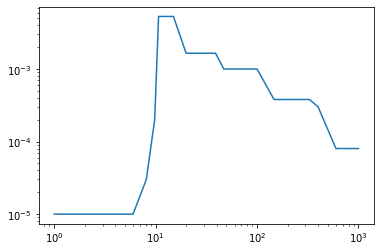

In [9]:
%matplotlib inline
ft = data[:,0]; pt = data[:,1];
plt.loglog(ft,pt);

In [10]:
fi = np.logspace(0,3,5000); pi = np.zeros(len(fi));
for i in range(len(pi)):
    pi[i] = 10**np.interp(np.log10(fi[i]),np.log10(ft),np.log10(pt));

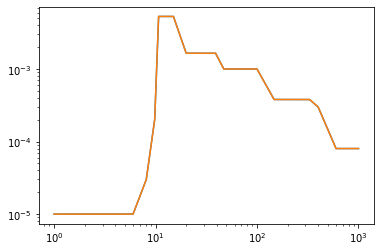

In [11]:
plt.loglog(fi,pi);
plt.loglog(ft,pt);

In [12]:
dfi,dpi = band_split(fi,pi,2);

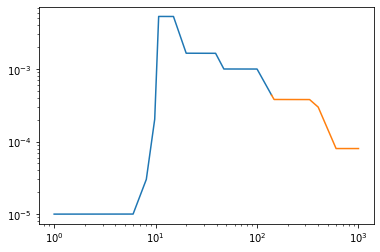

In [13]:
plt.loglog(dfi[0],dpi[0]);
plt.loglog(dfi[1],dpi[1]);

spec grms = 0.57  syn grms = 0.56

Number of Segment : 24 
Samples per Segment : 8192 
Time per Segment(sec) : 0.417 
df(Hz) : 2.40 
DOF : 48


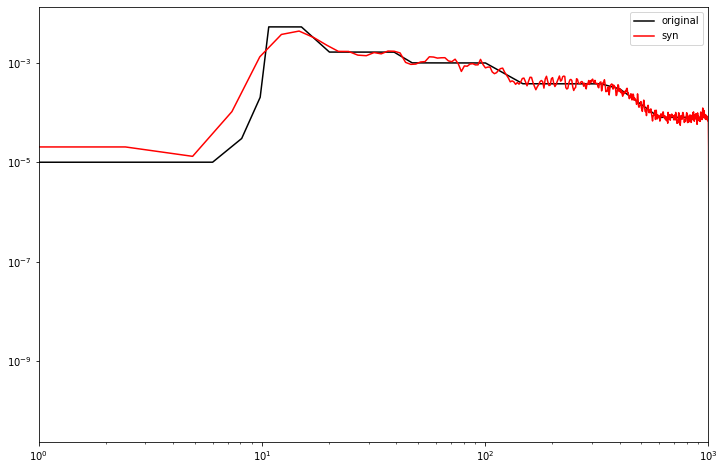

In [14]:
# PSD1
time0,th0 = psd2th_wn(fi,pi,10);
dt = 1/1000/20
time = np.arange(0,10+dt,dt);
th = np.interp(time,time0,th0);
# grms 비교
grms_spec = psdinteg(fi,pi); grms_syn = np.std(th);
print("spec grms = %.2f  syn grms = %.2f\n"%(grms_spec,grms_syn));
# PSD Check
sps = 2**13; 
dt = time[1]-time[0];
freq_syn,psd_syn = welch(th,fs = 1/dt,nperseg=sps);
plt.figure(figsize=(12,8));
plt.loglog(fi,pi,'k-',label='original');
#plt.loglog(fi,pi*1.1,'b--',label='original(10%)');
#plt.loglog(fi,pi/1.1,'b--',label='original(-10%)');
plt.loglog(freq_syn,psd_syn,'r-',label='syn'); plt.legend(loc='upper right');
plt.xlim(1,1000);

Nt = len(th); tmax = max(time); 
nos = int(Nt/sps); tps = tmax/nos; dof = nos*2; ddf = 1/tps; 
  
print("Number of Segment : %d \nSamples per Segment : %d \nTime per Segment(sec) : %.3f \ndf(Hz) : %.2f \nDOF : %d"%(nos,sps,tps,ddf,dof));

fileO(time,th,"th_fullPSD.txt");
fileO(fi,pi,"PSD_full.txt");
fileO(freq_syn,psd_syn,"PSD_syn_full.txt");

spec grms = 0.40  syn grms = 0.40

Number of Segment : 24 
Samples per Segment : 8192 
Time per Segment(sec) : 0.417 
df(Hz) : 2.40 
DOF : 48


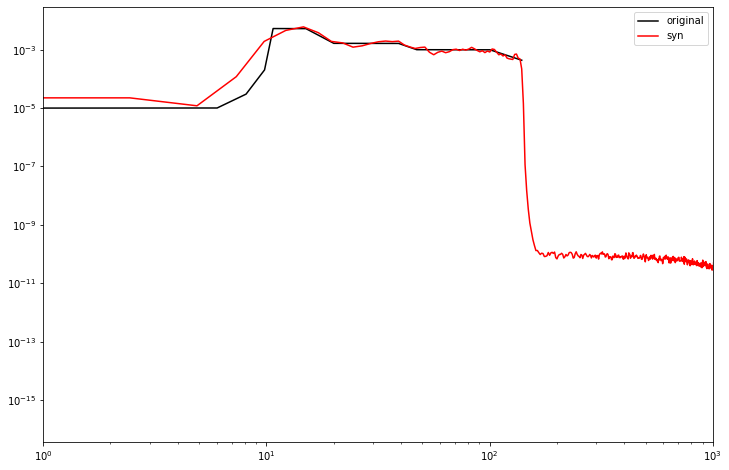

In [15]:
# PSD2
time0,th0 = psd2th_wn(dfi[0],dpi[0],10);
dt = 1/1000/20
time = np.arange(0,10+dt,dt);
th = np.interp(time,time0,th0);
# grms 비교
grms_spec = psdinteg(dfi[0],dpi[0]); grms_syn = np.std(th);
print("spec grms = %.2f  syn grms = %.2f\n"%(grms_spec,grms_syn));
# PSD Check
sps = 2**13; 
dt = time[1]-time[0];
freq_syn,psd_syn = welch(th,fs = 1/dt,nperseg=sps);
plt.figure(figsize=(12,8));
plt.loglog(dfi[0],dpi[0],'k-',label='original');
#plt.loglog(fi,pi*1.1,'b--',label='original(10%)');
#plt.loglog(fi,pi/1.1,'b--',label='original(-10%)');
plt.loglog(freq_syn,psd_syn,'r-',label='syn'); plt.legend(loc='upper right');
plt.xlim(1,1000);

Nt = len(th); tmax = max(time); 
nos = int(Nt/sps); tps = tmax/nos; dof = nos*2; ddf = 1/tps; 
  
print("Number of Segment : %d \nSamples per Segment : %d \nTime per Segment(sec) : %.3f \ndf(Hz) : %.2f \nDOF : %d"%(nos,sps,tps,ddf,dof));

fileO(time,th,"th_band1.txt");
fileO(dfi[0],dpi[0],"PSD_band1.txt");
fileO(freq_syn,psd_syn,"PSD_syn_band1.txt");

spec grms = 0.40  syn grms = 0.40

Number of Segment : 24 
Samples per Segment : 8192 
Time per Segment(sec) : 0.417 
df(Hz) : 2.40 
DOF : 48


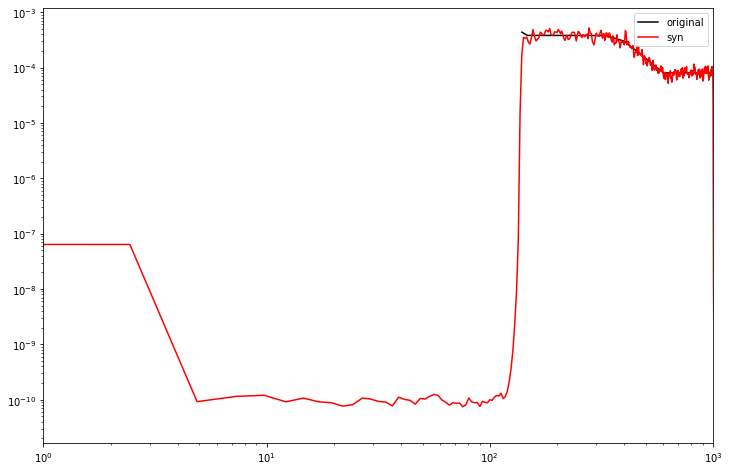

In [16]:
# PSD3
time0,th0 = psd2th_wn(dfi[1],dpi[1],10);
dt = 1/1000/20
time = np.arange(0,10+dt,dt);
th = np.interp(time,time0,th0);
# grms 비교
grms_spec = psdinteg(dfi[1],dpi[1]); grms_syn = np.std(th);
print("spec grms = %.2f  syn grms = %.2f\n"%(grms_spec,grms_syn));
# PSD Check
sps = 2**13; 
dt = time[1]-time[0];
freq_syn,psd_syn = welch(th,fs = 1/dt,nperseg=sps);
plt.figure(figsize=(12,8));
plt.loglog(dfi[1],dpi[1],'k-',label='original');
#plt.loglog(fi,pi*1.1,'b--',label='original(10%)');
#plt.loglog(fi,pi/1.1,'b--',label='original(-10%)');
plt.loglog(freq_syn,psd_syn,'r-',label='syn'); plt.legend(loc='upper right');
plt.xlim(1,1000);

Nt = len(th); tmax = max(time); 
nos = int(Nt/sps); tps = tmax/nos; dof = nos*2; ddf = 1/tps; 
  
print("Number of Segment : %d \nSamples per Segment : %d \nTime per Segment(sec) : %.3f \ndf(Hz) : %.2f \nDOF : %d"%(nos,sps,tps,ddf,dof));

fileO(time,th,"th_band2.txt");
fileO(dfi[1],dpi[1],"PSD_band2.txt");
fileO(freq_syn,psd_syn,"PSD_syn_band2.txt");

In [17]:
odfi,odpi = bs_overlap(dfi,dpi,0.1)
odpi *= 1.35;#확인필요

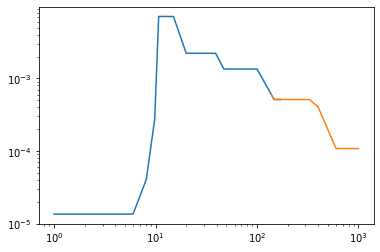

In [18]:
plt.loglog(odfi[0],odpi[0]);
plt.loglog(odfi[1],odpi[1]);

spec grms = 0.48  syn grms = 0.48

Number of Segment : 24 
Samples per Segment : 8192 
Time per Segment(sec) : 0.417 
df(Hz) : 2.40 
DOF : 48


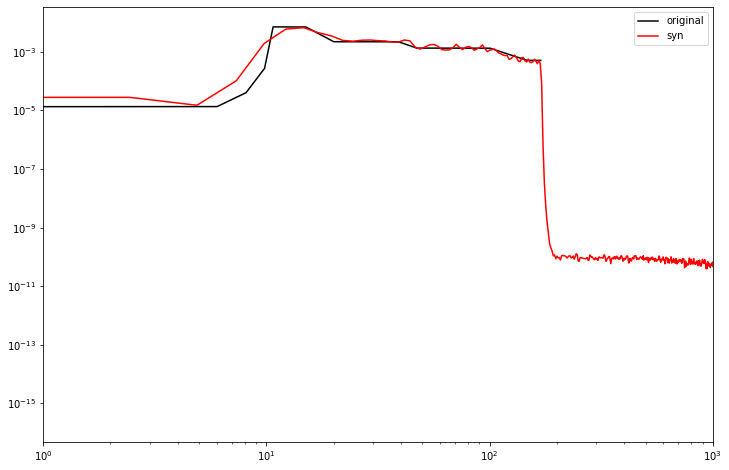

In [19]:
# PSD4
time0,th0= psd2th_wn(odfi[0],odpi[0],10);
dt = 1/1000/20
time = np.arange(0,10+dt,dt);
th = np.interp(time,time0,th0);
# grms 비교
grms_spec = psdinteg(odfi[0],odpi[0]); grms_syn = np.std(th);
print("spec grms = %.2f  syn grms = %.2f\n"%(grms_spec,grms_syn));
# PSD Check
sps = 2**13; 
dt = time[1]-time[0];
freq_syn,psd_syn = welch(th,fs = 1/dt,nperseg=sps);
plt.figure(figsize=(12,8));
plt.loglog(odfi[0],odpi[0],'k-',label='original');
#plt.loglog(fi,pi*1.1,'b--',label='original(10%)');
#plt.loglog(fi,pi/1.1,'b--',label='original(-10%)');
plt.loglog(freq_syn,psd_syn,'r-',label='syn'); plt.legend(loc='upper right');
plt.xlim(1,1000);

Nt = len(th); tmax = max(time); 
nos = int(Nt/sps); tps = tmax/nos; dof = nos*2; ddf = 1/tps; 
  
print("Number of Segment : %d \nSamples per Segment : %d \nTime per Segment(sec) : %.3f \ndf(Hz) : %.2f \nDOF : %d"%(nos,sps,tps,ddf,dof));

fileO(time,th,"th_ovl_band1.txt");
fileO(odfi[0],odpi[0],"PSD_ovl_band1.txt");
fileO(freq_syn,psd_syn,"PSD_syn_ovl_band1.txt");

spec grms = 0.47  syn grms = 0.46

Number of Segment : 24 
Samples per Segment : 8192 
Time per Segment(sec) : 0.417 
df(Hz) : 2.40 
DOF : 48


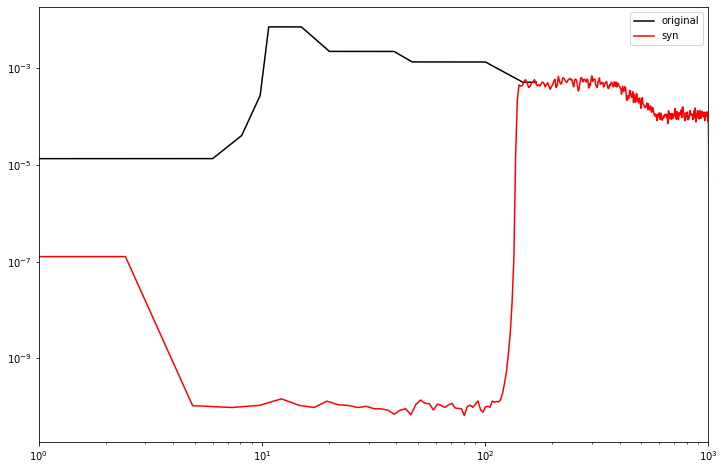

In [20]:
# PSD5
time0,th0 = psd2th_wn(odfi[1],odpi[1],10);
dt = 1/1000/20
time = np.arange(0,10+dt,dt);
th = np.interp(time,time0,th0);
# grms 비교
grms_spec = psdinteg(odfi[1],odpi[1]); grms_syn = np.std(th);
print("spec grms = %.2f  syn grms = %.2f\n"%(grms_spec,grms_syn));
# PSD Check
sps = 2**13; 
dt = time[1]-time[0];
freq_syn,psd_syn = welch(th,fs = 1/dt,nperseg=sps);
plt.figure(figsize=(12,8));
plt.loglog(odfi[0],odpi[0],'k-',label='original');
#plt.loglog(fi,pi*1.1,'b--',label='original(10%)');
#plt.loglog(fi,pi/1.1,'b--',label='original(-10%)');
plt.loglog(freq_syn,psd_syn,'r-',label='syn'); plt.legend(loc='upper right');
plt.xlim(1,1000);

Nt = len(th); tmax = max(time); 
nos = int(Nt/sps); tps = tmax/nos; dof = nos*2; ddf = 1/tps; 
  
print("Number of Segment : %d \nSamples per Segment : %d \nTime per Segment(sec) : %.3f \ndf(Hz) : %.2f \nDOF : %d"%(nos,sps,tps,ddf,dof));

fileO(time,th,"th_ovl_band2.txt");
fileO(odfi[1],odpi[1],"PSD_ovl_band2.txt");
fileO(freq_syn,psd_syn,"PSD_syn_ovl_band2.txt");